# Unified Architecture

> **Created by:** Mario Boley  
> **On:** 2025-06-16

This study aims to develop a unified architecture that allows (in order of importance):

1. Code reuse between different loss function, in particular for classifiers and regressors
2. Code reuse between different boosting routines, including different objective functions
3. Incremental computation of the Gramian and potentially other objects across boosting iterations
4. Use of numba jit for the main boosting loop
5. Use of other, i.e., non-rule, base learners

## Test Data

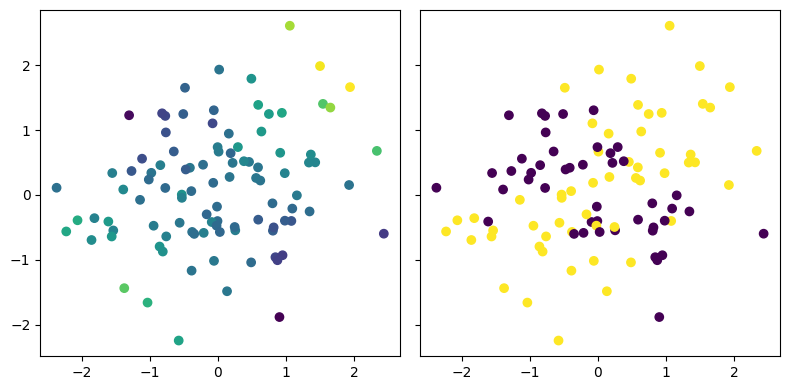

In [38]:
import numpy as np
from scipy.special import expit
from matplotlib import pyplot as plt

RNG = np.random.default_rng(0)

cov = np.array(
    [[1, 0.2], 
     [0.2, 1]]
)

x = RNG.multivariate_normal([0, 0], cov, size=100)
y_regr = x[:, 0] * x[:, 1] + RNG.normal(scale=0.25, size=100)
y_class = RNG.binomial(n=1, p=expit(4 * x[:, 0] * x[:, 1]))

_, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True, tight_layout=True)
axs[0].scatter(x[:, 0], x[:, 1], c=y_regr)
axs[1].scatter(x[:, 0], x[:, 1], c=y_class)
plt.show()

## Specialised Rule Boosting Regression Implementation

This implementation is taken from the [shrinkage spike](shrinkage.ipynb). It contains the options for a background rule, $l2$-regularisation, and norm-based normalisation during fitting.

In [77]:
from optikon import max_weighted_support, equal_width_propositionalization
from sklearn.metrics import mean_squared_error

class RuleBoostingRegressor:

    def __init__(self, num_rules=3, fit_intercept=True, lam=0.0, normalize_during_weight_fit=False, max_depth=5):
        self.num_rules = num_rules
        self.fit_intercept = fit_intercept
        self.max_depth = max_depth
        self.normalize_during_weight_fit = normalize_during_weight_fit
        self.lam = lam

    def fit(self, x, y):
        n = len(x)
        props = equal_width_propositionalization(x)
        
        q_matrix = np.zeros(shape=(n, self.num_rules+self.fit_intercept))

        if self.fit_intercept:
            self.q_ = [props[:0]]
            q_matrix[:, 0] = 1
            self.coef_ = np.array([y.mean()])
        else:
            self.q_ = []
            q_matrix = np.zeros(shape=(n, self.num_rules))
            self.coef_ = np.zeros(shape=0)

        for i in range(self.fit_intercept, self.num_rules+self.fit_intercept):
            y_hat = q_matrix[:, :i].dot(self.coef_) 
            g = y - y_hat

            opt_key_pos, opt_val_pos, _, _ = max_weighted_support(x, g, props, self.max_depth)
            opt_key_neg, opt_val_neg, _, _ = max_weighted_support(x, -g, props, self.max_depth)
            if opt_val_pos >= opt_val_neg:
                self.q_.append(props[opt_key_pos])
            else:
                self.q_.append(props[opt_key_neg])

            q_matrix[self.q_[i].support_all(x), i] = 1
            self._fit_coefficients(y, q_matrix[:, :i+1])

        return self

    def _fit_coefficients(self, y, q_matrix):
        
        if self.normalize_during_weight_fit:
            b = q_matrix.sum(axis=0)**0.5 / len(y)**0.5
            q_matrix = q_matrix / b

        gramian = q_matrix.T.dot(q_matrix)

        if self.lam > 0:
            if self.fit_intercept:
                gramian[np.diag_indices_from(gramian)[0][1:], np.diag_indices_from(gramian)[1][1:]] += self.lam
            else:
                gramian[np.diag_indices_from(gramian)] += self.lam

        self.coef_ = np.linalg.solve(gramian, q_matrix.T.dot(y))

        if self.normalize_during_weight_fit:
            self.coef_ /= b
    
    def predict(self, x):
        q_matrix = self._compute_q_matrix(x)
        return q_matrix.dot(self.coef_)

    def _compute_q_matrix(self, x):
        n = len(x)
        q_matrix = np.zeros(shape=(n, len(self.q_)))
        for i in range(len(self.q_)):
            q_matrix[self.q_[i].support_all(x), i] = 1
        return q_matrix
    
    def __str__(self):
        res = ''
        for i in range(len(self.q_)):
            res += f'{self.coef_[i]:+.3f} if {self.q_[i].str_from_conj(np.arange(len(self.q_[i])))} {'\n' if i<len(self.q_)-1 else ''}'
        return res
    
    def __repr__(self):
        return f'RuleBoostingRegressor({self.num_rules}, {self.max_depth})'
    
regressor = RuleBoostingRegressor(num_rules=3, fit_intercept=True, lam=1).fit(x, y_regr)
print(regressor)
mean_squared_error(y_regr, regressor.predict(x))



+0.351 if  
+1.528 if x1 >= 0.343 & x2 >= 0.331 
-0.875 if x1 >= 0.343 & x2 <= 0.846 
-0.687 if x1 <= 1.021 & x2 >= 0.331 


0.2912827717630902

## Separation of Loss Function and Boosting Loop

In [82]:
class PythonIncrementalSquaredLossOptimizer:

    def __init__(self, y, max_features, intercept=True, lam=0.0):
        self.y = y
        self.max_features = max_features
        self.intercept = intercept
        self.x = np.zeros(shape=(len(y), self.max_features+self.intercept))
        self.lam = lam

        if self.intercept:
            self.x[:, 0] = 1
            self.coef = np.array([y.mean()])
            self.current_features = 1
        else:
            self.coef = np.zeros(shape=0)
            self.current_features = 0

    def add_feature(self, col):
        self.x[:, self.current_features] = col
        self.current_features += 1

    def add_sparse_feature(self, idx, vals):
        self.x[idx, self.current_features] = vals
        self.current_features += 1

    def gradient(self):
        return self.y - self.x[:, :self.current_features].dot(self.coef)

    def hessian_diagonal(self):
        return 1

    def optimize_coefficients(self):
        gramian = self.x[:, :self.current_features].T.dot(self.x[:, :self.current_features])

        # n = self.current_features
        # if self.lam > 0:
        #     if self.intercept:
        #         for i in range(1, n):
        #             gramian[i, i] += self.lam
        #     else:
        #         for i in range(n):
        #             gramian[i, i] += self.lam

        # if self.lam > 0:
        #     for i in range(self.intercept, self.current_features):
        #         gramian[i, i] += self.lam

        if self.lam > 0:
            if self.intercept:
                gramian[np.diag_indices_from(gramian)[0][1:], np.diag_indices_from(gramian)[1][1:]] += self.lam
            else:
                gramian[np.diag_indices_from(gramian)] += self.lam
            
        self.coef = np.linalg.solve(gramian, self.x[:, :self.current_features].T.dot(self.y))

def python_gradient_sum_booster(x, props, num_rules, fit_intercept, coefficient_optimizer, max_depth=5):
    qs = []
    if fit_intercept:
        qs.append(props[0:0]) 
    # qs = [props[:0]] if fit_intercept else []
    for _ in range(num_rules):
        g = coefficient_optimizer.gradient()

        opt_key_pos, opt_val_pos, _, _ = max_weighted_support(x, g, props, max_depth)
        opt_key_neg, opt_val_neg, _, _ = max_weighted_support(x, -g, props, max_depth)
        if opt_val_pos >= opt_val_neg:
            qs.append(props[opt_key_pos])
        else:
            qs.append(props[opt_key_neg])

        coefficient_optimizer.add_sparse_feature(qs[-1].support_all(x), 1)
        coefficient_optimizer.optimize_coefficients()
    return coefficient_optimizer.coef, qs

class PythonNewRuleBoostingRegressor:

    def __init__(self, num_rules=3, fit_intercept=True, lam=0.0, max_depth=5):
        self.num_rules = num_rules
        self.fit_intercept = fit_intercept
        self.max_depth = max_depth
        self.lam = lam

    def fit(self, x, y):
        optimizer = PythonIncrementalSquaredLossOptimizer(y, self.num_rules, intercept=self.fit_intercept, lam=self.lam)
        props = equal_width_propositionalization(x)
        self.coef_, self.q_ = python_gradient_sum_booster(x, props, self.num_rules, fit_intercept=self.fit_intercept, coefficient_optimizer=optimizer, max_depth=self.max_depth)
        return self
    
    def predict(self, x):
        q_matrix = self._compute_q_matrix(x)
        return q_matrix.dot(self.coef_)

    def _compute_q_matrix(self, x):
        n = len(x)
        q_matrix = np.zeros(shape=(n, len(self.q_)))
        for i in range(len(self.q_)):
            q_matrix[self.q_[i].support_all(x), i] = 1
        return q_matrix
    
    def __str__(self):
        res = ''
        for i in range(len(self.q_)):
            res += f'{self.coef_[i]:+.3f} if {self.q_[i].str_from_conj(np.arange(len(self.q_[i])))} {'\n' if i<len(self.q_)-1 else ''}'
        return res
    
    def __repr__(self):
        return f'PythonNewRuleBoostingRegressor({self.num_rules}, {self.max_depth})'


python_new_regressor = PythonNewRuleBoostingRegressor(num_rules=3, fit_intercept=True, lam=1).fit(x, y_regr)
print(python_new_regressor)
mean_squared_error(y_regr, python_new_regressor.predict(x))

+0.351 if  
+1.528 if x1 >= 0.343 & x2 >= 0.331 
-0.875 if x1 >= 0.343 & x2 <= 0.846 
-0.687 if x1 <= 1.021 & x2 >= 0.331 


0.2912827717630902

## Numba Implementation

In [ ]:
from numba.experimental import jitclass
from numba.types import float64, boolean, int64
from numba import njit
from numba.typed import List

spec = [
    ('y', float64[:]),
    ('x', float64[:, :]),
    ('coef', float64[:]),
    ('lam', float64),
    ('intercept', boolean),
    ('max_features', int64),
    ('current_features', int64),
]
@jitclass(spec)
class IncrementalSquaredLossOptimizer:

    def __init__(self, y, max_features, intercept=True, lam=0.0):
        self.y = y
        self.max_features = max_features
        self.intercept = intercept
        self.x = np.zeros(shape=(len(y), self.max_features+self.intercept))
        self.lam = lam

        if self.intercept:
            self.x[:, 0] = 1
            self.coef = np.array([y.mean()])
            self.current_features = 1
        else:
            self.coef = np.zeros(shape=0)
            self.current_features = 0

    def add_feature(self, col):
        self.x[:, self.current_features] = col
        self.current_features += 1

    def add_sparse_feature(self, idx, vals):
        self.x[idx, self.current_features] = vals
        self.current_features += 1

    def gradient(self):
        return self.y - self.x[:, :self.current_features].dot(self.coef)

    def hessian_diagonal(self):
        return 1

    def optimize_coefficients(self):
        gramian = self.x[:, :self.current_features].T.dot(self.x[:, :self.current_features])

        if self.lam > 0:
            for i in range(self.intercept, self.current_features):
                gramian[i, i] += self.lam
            
        self.coef = np.linalg.solve(gramian, self.x[:, :self.current_features].T.dot(self.y))

@njit
def gradient_sum_booster(x, props, num_rules, fit_intercept, coefficient_optimizer, max_depth=5):
    qs = List()
    if fit_intercept:
        qs.append(props[0:0]) 
    # qs = [props[:0]] if fit_intercept else []
    for _ in range(num_rules):
        g = coefficient_optimizer.gradient()

        opt_key_pos, opt_val_pos, _, _ = max_weighted_support(x, g, props, max_depth)
        opt_key_neg, opt_val_neg, _, _ = max_weighted_support(x, -g, props, max_depth)
        if opt_val_pos >= opt_val_neg:
            qs.append(props[opt_key_pos])
        else:
            qs.append(props[opt_key_neg])

        coefficient_optimizer.add_sparse_feature(qs[-1].support_all(x), 1)
        coefficient_optimizer.optimize_coefficients()
    return coefficient_optimizer.coef, qs

class NewRuleBoostingRegressor:

    def __init__(self, num_rules=3, fit_intercept=True, lam=0.0, max_depth=5):
        self.num_rules = num_rules
        self.fit_intercept = fit_intercept
        self.max_depth = max_depth
        self.lam = lam

    def fit(self, x, y):
        optimizer = IncrementalSquaredLossOptimizer(y, self.num_rules, intercept=self.fit_intercept, lam=self.lam)
        props = equal_width_propositionalization(x)
        self.coef_, self.q_ = gradient_sum_booster(x, props, self.num_rules, fit_intercept=self.fit_intercept, coefficient_optimizer=optimizer, max_depth=self.max_depth)
        return self
    
    def predict(self, x):
        q_matrix = self._compute_q_matrix(x)
        return q_matrix.dot(self.coef_)

    def _compute_q_matrix(self, x):
        n = len(x)
        q_matrix = np.zeros(shape=(n, len(self.q_)))
        for i in range(len(self.q_)):
            q_matrix[self.q_[i].support_all(x), i] = 1
        return q_matrix
    
    def __str__(self):
        res = ''
        for i in range(len(self.q_)):
            res += f'{self.coef_[i]:+.3f} if {self.q_[i].str_from_conj(np.arange(len(self.q_[i])))} {'\n' if i<len(self.q_)-1 else ''}'
        return res
    
    def __repr__(self):
        return f'NewRuleBoostingRegressor({self.num_rules}, {self.max_depth})'


new_regressor = NewRuleBoostingRegressor(num_rules=3, fit_intercept=True, lam=1).fit(x, y_regr)
print(new_regressor)
mean_squared_error(y_regr, new_regressor.predict(x))


+0.351 if  
+1.528 if x1 >= 0.343 & x2 >= 0.331 
-0.875 if x1 >= 0.343 & x2 <= 0.846 
-0.687 if x1 <= 1.021 & x2 >= 0.331 


0.2912827717630902

In [84]:
%timeit PythonNewRuleBoostingRegressor(num_rules=200, fit_intercept=True, lam=1).fit(x, y_regr)

1.86 s ± 36.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [91]:
%timeit NewRuleBoostingRegressor(num_rules=200, fit_intercept=True, lam=1).fit(x, y_regr)

1.87 s ± 33.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
